# Задание 1

In [1]:
import re
import os
from typing import List, Dict, Tuple, Optional, Callable
from collections import defaultdict
import yaml
import pandas as pd
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt


In [2]:
class BPETokenizer:
    def __init__(self,
                 vocab_size: int,
                 pattern: Optional[str] = None,
                 special_tokens: Dict[str, int] = {}):
        self.vocab_size = vocab_size
        
        if '<UNK>' not in special_tokens:
            special_tokens['<UNK>'] = len(special_tokens)
        self.special_tokens = special_tokens
        
        self.merges: List[Tuple[bytes, bytes]] = []
        self.byte_encoder: Dict[int, bytes] = {}
        self.vocab = self._build_vocab()
        self.pretokenizer = self._get_pretokenizer(pattern)
    
    def _get_pretokenizer(self, pattern: Optional[str]) -> Callable[[str], List[List[int]]]:
        regex = re.compile(pattern if pattern else r"\s+|\S+")
        
        def pretokenize(text: str) -> List[List[int]]:
            words = regex.findall(text)
            encoded_words = []
            for word in words:
                word_encoded = [self.vocab.get(bytes([b]), self.special_tokens['<UNK>'])
                                for b in word.encode("utf-8")]
                encoded_words.append(word_encoded)
            return encoded_words
        
        return pretokenize
    
    def _build_vocab(self) -> Dict[bytes, int]:
        vocab = {token.encode("utf-8"): idx for token, idx in self.special_tokens.items()}
        offset = len(vocab)
        vocab.update({bytes([i]): offset + i for i in range(256)})
        
        offset = len(vocab)
        for idx, (p0, p1) in enumerate(self.merges):
            vocab[p0 + p1] = offset + idx
            
        self.byte_encoder = {v: k for k, v in vocab.items()}
            
        return vocab

    def _get_stats(self, encoded_words: List[List[int]]) -> Dict[Tuple[int, int], int]:
        counts = defaultdict(int)
        for word in encoded_words:
            for i in range(len(word) - 1):
                counts[(word[i], word[i+1])] += 1
        return counts

    def _merge_ids(self, encoded_words: List[List[int]], pair: Tuple[int, int], new_id: int) -> List[List[int]]:
        new_encoded_words = []
        p0, p1 = pair
        
        for word in encoded_words:
            new_word = []
            i = 0
            while i < len(word):
                if i < len(word) - 1 and word[i] == p0 and word[i + 1] == p1:
                    new_word.append(new_id)
                    i += 2 
                else:
                    new_word.append(word[i])
                    i += 1
            new_encoded_words.append(new_word)
        return new_encoded_words

    def fit(self, texts: List[str]) -> None:
        pretokenized_texts = []
        for text in tqdm(texts, desc="Pretokenizing"):
            pretokenized_texts.append(self.pretokenizer(text))
            
        encoded_words = sum(pretokenized_texts, [])
        curr_vocab_size = len(self.vocab)
        
        target_merges = self.vocab_size - curr_vocab_size
        with tqdm(total=target_merges, desc="BPE training") as pbar:
            while curr_vocab_size < self.vocab_size:
                stats = self._get_stats(encoded_words)
                if len(stats) == 0:
                    self._build_vocab()
                    return self

                best_pair = max(stats, key=stats.get)
                p0_bytes = self.byte_encoder[best_pair[0]]
                p1_bytes = self.byte_encoder[best_pair[1]]
                new_token_bytes = p0_bytes + p1_bytes

                self.merges.append((p0_bytes, p1_bytes))
                self.vocab[new_token_bytes] = curr_vocab_size
                self.byte_encoder[curr_vocab_size] = new_token_bytes

                encoded_words = self._merge_ids(encoded_words, best_pair, curr_vocab_size)

                curr_vocab_size += 1
                
                pbar.update(1)
            
        self.vocab = self._build_vocab()
        
        return self

    def encode(self, text: str) -> List[int]:
        encoded_words = self.pretokenizer(text)
        
        for p0_bytes, p1_bytes in self.merges:
            idx0 = self.vocab.get(p0_bytes)
            idx1 = self.vocab.get(p1_bytes)
            
            merged_bytes = p0_bytes + p1_bytes
            merged_idx = self.vocab.get(merged_bytes)
            
            if idx0 is not None and idx1 is not None and merged_idx is not None:
                encoded_words = self._merge_ids(encoded_words, (idx0, idx1), merged_idx)
        token_ids = []
        for word in encoded_words:
            token_ids.extend(word)
              
        return token_ids

    def decode(self, token_ids: List[int]) -> str:
        unk = self.byte_encoder[self.special_tokens['<UNK>']]
        decoded_bytes = b"".join([self.byte_encoder.get(idx, unk)
                                  for idx in token_ids])
        
        return decoded_bytes.decode("utf-8")

In [4]:
text = "Я в своем познании настолько преисполнился, что я как будто бы уже сто триллионов миллиардов лет проживаю на триллионах и триллионах таких же планет, как эта Земля, мне этот мир абсолютно понятен, и я здесь ищу только одного - покоя, умиротворения и вот этой гармонии, от слияния с бесконечно вечным, от созерцания великого фрактального подобия и от вот этого замечательного всеединства существа, бесконечно вечного, куда ни посмотри, хоть вглубь - бесконечно малое, хоть ввысь - бесконечное большое, понимаешь? А ты мне опять со своим вот этим, иди суетись дальше, это твоё распределение, это твой путь и твой горизонт познания и ощущения твоей природы, он несоизмеримо мелок по сравнению с моим, понимаешь? Я как будто бы уже давно глубокий старец, бессмертный, ну или там уже почти бессмертный, который на этой планете от её самого зарождения, ещё когда только Солнце только-только сформировалось как звезда, и вот это газопылевое облако, вот, после взрыва, Солнца, когда оно вспыхнуло, как звезда, начало формировать вот эти коацерваты, планеты, понимаешь, я на этой Земле уже как будто почти пять миллиардов лет живу и знаю её вдоль и поперёк этот весь мир, а ты мне какие-то... мне не важно на твои тачки, на твои яхты, на твои квартиры, там, на твоё благо. Я был на этой планете бесконечным множеством, и круче Цезаря, и круче Гитлера, и круче всех великих, понимаешь, был, а где-то был конченым говном, ещё хуже, чем здесь. Я множество этих состояний чувствую. Где-то я был больше подобен растению, где-то я больше был подобен птице, там, червю, где-то был просто сгусток камня, это всё есть душа, понимаешь? Она имеет грани подобия совершенно многообразные, бесконечное множество. Но тебе этого не понять, поэтому ты езжай себе , мы в этом мире как бы живем разными ощущениями и разными стремлениями, соответственно, разное наше и место, разное и наше распределение. Тебе я желаю все самые крутые тачки чтоб были у тебя, и все самые лучше самки, если мало идей, обращайся ко мне, я тебе на каждую твою идею предложу сотню триллионов, как всё делать. Ну а я всё, я иду как глубокий старец,узревший вечное, прикоснувшийся к Божественному, сам стал богоподобен и устремлен в это бесконечное, и который в умиротворении, покое, гармонии, благодати, в этом сокровенном блаженстве пребывает, вовлеченный во всё и во вся, понимаешь, вот и всё, в этом наша разница. Так что я иду любоваться мирозданием, а ты идёшь преисполняться в ГРАНЯХ каких-то, вот и вся разница, понимаешь, ты не зришь это вечное бесконечное, оно тебе не нужно. Ну зато ты, так сказать, более активен, как вот этот дятел долбящий, или муравей, который очень активен в своей стезе, поэтому давай, наши пути здесь, конечно, имеют грани подобия, потому что всё едино, но я-то тебя прекрасно понимаю, а вот ты меня - вряд ли, потому что я как бы тебя в себе содержу, всю твою природу, она составляет одну маленькую там песчиночку, от того что есть во мне, вот и всё, поэтому давай, ступай, езжай, а я пошел наслаждаться прекрасным осенним закатом на берегу теплой южной реки. Всё, ступай, и я пойду."
tokenizer = BPETokenizer(vocab_size=512).fit([text])

BPE training: 100%|██████████| 255/255 [00:00<00:00, 1377.83it/s]


In [21]:
text = "Hi! Please help me to write 你好 in english!"
tokenizer.decode(tokenizer.encode(text))

'Hi! Please help me to write 你好 in english!'

In [6]:
dirs = None
with open('../dirs.yaml', 'r') as file:
    dirs = yaml.safe_load(file)['homework-3']

In [3]:
VOCAB_SIZE = 3000
SPECIAL_TOKENS = {'<PAD>': 0,
                  '<UNK>': 1,
                  '<BOS>': 2,
                  '<EOS>': 3,}
PATTERN = r"""'s|'t|'re|'ve|'m|'ll|'d| ?[A-Za-z]+| ?\d+| ?[^\sA-Za-z\d]+|\s+(?!\S)|\s+""" # GPT-2

Обучите свой токенизатор на своем корпусе, токенизируйте тексты, не совпадающие с использованным для обучения.

**Идея:** Обучить токенизатор на русских шутках, альтернативных токенизатор на советсий стихотворениях. В качестве тестового набора - стихотворения времен российской империи

In [4]:
def compression_ratio(texts: List[str], tokenizer: BPETokenizer):
    total_tokens = 0
    total_bytes = 0
    
    for t in texts:
        total_tokens += len(tokenizer.encode(t))
        total_bytes += len(t.encode("utf-8"))
        
    return total_tokens / total_bytes

def avg_tokens_per_word(texts: List[str], tokenizer: BPETokenizer):
    total_tokens = 0
    total_words = 0
    
    for t in texts:
        words = t.split()
        total_words += len(words)
        for w in words:
            total_tokens += len(tokenizer.encode(w))
            
    return total_tokens / total_words


def avg_tokens_top_freq_words(texts: List[str], tokenizer: BPETokenizer, top_ratio: float = 0.1):
    word_freq = Counter()
    
    for t in texts:
        word_freq.update(t.split())
        
    top_k = int(len(word_freq) * top_ratio)
    top_words = {w for w, _ in word_freq.most_common(top_k)}
    
    total_tokens = 0
    total_words = 0
    
    for w in top_words:
        total_tokens += len(tokenizer.encode(w))
        total_words += 1
        
    return total_tokens / total_words

In [ ]:
df = pd.read_csv(dirs['jokes'])[:3000]
train_texts = df['text']
joke_tokenizer = BPETokenizer(VOCAB_SIZE, PATTERN, SPECIAL_TOKENS).fit(train_texts)

BPE training:   0%|          | 11/2740 [00:03<14:04,  3.23it/s]


KeyboardInterrupt: 

In [ ]:
df = pd.read_csv(dirs['poems'])
train_texts = list(df['text'])
train_texts.sort(key=lambda x: len(x))
train_texts = train_texts[:3078]# такой срез берется, чтобы было примерно одинаковое количество символов
ussr_tokenizer = BPETokenizer(VOCAB_SIZE, PATTERN, SPECIAL_TOKENS).fit(train_texts)

BPE training: 100%|██████████| 2740/2740 [13:35<00:00,  3.36it/s]


In [64]:
df = pd.read_csv(dirs['poems'])
valid_poem_data_from = (df["date_from"] >= 1721) & (df["date_from"] <= 1917)
valid_poem_data_to   = (df["date_to"]   >= 1721) & (df["date_to"]   <= 1917)
df = df[valid_poem_data_from & valid_poem_data_from]

test_texts = list(df['text'][:100])

In [67]:
metrics = {"compression ratio":compression_ratio,
           "avg tokens per word": avg_tokens_per_word,
           "avg tokens top 0.1 freq words": avg_tokens_top_freq_words}

results = dict.fromkeys(metrics.keys())

tokenizers = [joke_tokenizer, ussr_tokenizer]

for name, metric in metrics.items():
    results[name] = [metric(test_texts, joke_tokenizer), metric(test_texts, ussr_tokenizer)]

pd.DataFrame(results, index=['Joke', 'USSR'])

,compression ratio,avg tokens per word,avg tokens top 0.1 freq words
Joke,0.272502,2.851595,2.568075
USSR,0.229115,2.541808,2.200313


**Вывод:** tokenizer USSR лучше сжимает стихотворения, написанные во времена Российский Империи. Из этого можно сделать вывод, что эффективность действительно отличается и может зависеть от того, насколько близко к "тестовой" тематике, тематика, на которой tokenizer учился

BPE training: 100%|██████████| 4740/4740 [05:09<00:00, 15.32it/s]


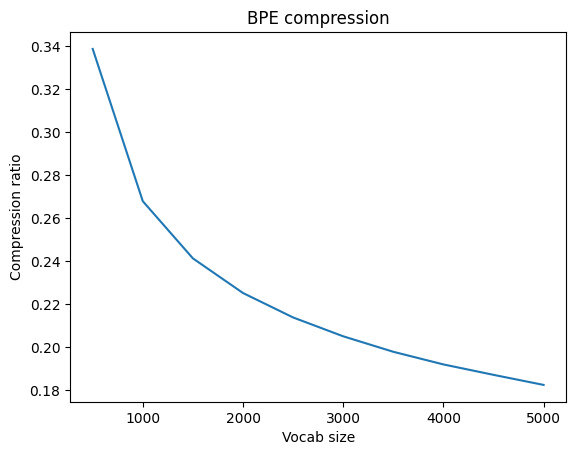

In [9]:
texts = pd.read_csv(dirs['jokes'])[:1000]['text']

vocab_sizes = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
ratios = []

for vs in vocab_sizes:
    tokenizer = BPETokenizer(vocab_size=vs, pattern=PATTERN, special_tokens=SPECIAL_TOKENS)
    tokenizer.fit(texts)
    ratios.append(compression_ratio(texts, tokenizer))
    
plt.plot(vocab_sizes, ratios)
plt.xlabel("Vocab size")
plt.ylabel("Compression ratio")
plt.title("BPE compression")
plt.show()

In [70]:
pushkin_poems = []
for filename in os.listdir(dirs['pushkin']):
    if filename.endswith(".txt"):
        with open(os.path.join(dirs['pushkin'], filename), encoding="utf-8") as f:
            pushkin_poems.append(f.read())
            
def unused_tokens(tokenizer: BPETokenizer):
    used = set()
    for t in pushkin_poems:
        used.update(tokenizer.encode(t))
        
    all_tokens = set(tokenizer.vocab.values())
    unused = all_tokens - used
    
    return len(unused), len(all_tokens), len(unused) / len(all_tokens)

f"USSR: {unused_tokens(ussr_tokenizer)}, Joke: {unused_tokens(joke_tokenizer)}"

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7bd587293f90>>
Traceback (most recent call last):
  File "/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


'USSR: (186, 3000, 0.062), Joke: (643, 3000, 0.21433333333333332)'

### Задание 1.1 

In [82]:
import torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch import cuda
from torch.optim import Optimizer, Adam
from torch.utils.data import Dataset
from numpy.typing import NDArray

In [83]:
class ModelTrainer:
    def __init__(self,
                 num_epochs: int,
                 batch_size: int,
                 pad_token_id: int = 0,
                 device: torch.device | None = None):
        
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.pad_token_id = pad_token_id
        self.device = device
        
        if self.device is None:
            self.device = torch.device('cuda' if cuda.is_available() else 'cpu')
            
        self.model = None
        self.loss_history = None
        self.criterion = None
        
    def train(self,
              data: Dataset,
              model: nn.Module,
              optimizer: Optimizer,
              criterion: nn.Module,
              ) -> NDArray[np.float64]:
        
        dataloader = DataLoader(data, batch_size=self.batch_size, shuffle=True)
        model = model.to(self.device)
        self.criterion = criterion
        
        model.train()
        loss_history = []

        with tqdm(total=len(dataloader) * self.num_epochs, unit="batch", position=0, leave=True) as pbar:
            for epoch in range(self.num_epochs):
                running_loss = 0.0

                for batch_num, batch in enumerate(dataloader):

                    source = batch[0].to(self.device) 
                    target_labels = batch[1].to(self.device)

                    optimizer.zero_grad()
                    
                    outputs = model(source)

                    loss = criterion(
                        outputs.contiguous().view(-1, outputs.size(-1)),
                        target_labels.contiguous().view(-1)
                    )

                    loss.backward()
                    
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                    optimizer.step()

                    running_loss += loss.item()
                    pbar.set_postfix({
                        "Epoch": f"{epoch + 1}/{self.num_epochs}",
                        "Loss": f"{loss.item():.4f}"
                    })
                    pbar.update()

                avg_epoch_loss = running_loss / len(dataloader)
                loss_history.append(avg_epoch_loss)
                pbar.set_postfix({"Epoch Loss": f"{avg_epoch_loss:.4f}"})

            pbar.close()
        
        self.model = model
        self.loss_history = np.array(loss_history)

        return self.test(data)
    
    def test(self, data: Dataset) -> NDArray[np.float64]:
        if self.model is None:
            raise ValueError("Модель не обучена или не установлена.")
        
        self.model.eval()
        dataloader = DataLoader(data, batch_size=self.batch_size)
        test_losses = []

        with torch.no_grad():
            for batch in dataloader:
                source = batch[0].to(self.device)
                target_labels = batch[1].to(self.device)

                outputs = self.model(source)
                loss = self.criterion(
                    outputs.contiguous().view(-1, outputs.size(-1)),
                    target_labels.contiguous().view(-1)
                )
                test_losses.append(loss.item())

        return np.array(test_losses)
    
    def print_loss_history(self, path_save: str | None = None) -> None:
        if self.loss_history is None:
            raise ValueError("Нет данных о loss. Сначала вызовите train().")

        plt.figure(figsize=(8, 5))
        plt.plot(self.loss_history, label="Train Loss")
        plt.title("Training Loss per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True, alpha=0.3)
        plt.legend()
        if path_save:
            plt.savefig(f"{path_save}.png", dpi=200, bbox_inches='tight')
            print(f"График сохранён: {path_save}.png")
        else:
            plt.show()

In [84]:
class TextDataset(Dataset):
    def __init__(self,
                 texts: List[str], 
                 tokenizer: BPETokenizer,
                 max_length: int):
        self.tokenizer = tokenizer
        self.data = []
        
        for text in texts:
            tokens = tokenizer.encode(text)
            tokens = tokens + [tokenizer.special_tokens['<EOS>']]
            if len(tokens) > max_length:
                tokens = tokens[:max_length]
            
            pad_len = max_length - len(tokens)
            tokens = tokens + [tokenizer.special_tokens['<PAD>']] * pad_len
            
            self.data.append(torch.tensor(tokens, dtype=torch.long))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens = self.data[idx]
        return tokens[:-1], tokens[1:]

In [85]:
class Model(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x):
        embeds = self.embedding(x)
        output, _ = self.lstm(embeds)
        logits = self.fc(output)
        return logits


In [92]:
EMBED_SIZE = 256
HIDDEN_SIZE = 512
BATCH_SIZE = 32
EPOCHS = 50
LR = 1e-3
trainer = ModelTrainer(num_epochs=EPOCHS,
                       batch_size=BATCH_SIZE, 
                       pad_token_id=ussr_tokenizer.special_tokens['<PAD>'],
                       device='cuda')

texts = pd.read_csv(dirs['jokes'])[:1000]['text']

dataset = TextDataset(texts, joke_tokenizer, max_length=128)
model = Model(joke_tokenizer.vocab_size, EMBED_SIZE, HIDDEN_SIZE)
optimizer = Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index=joke_tokenizer.special_tokens['<PAD>'])


In [93]:
trainer.train(dataset, model, optimizer, criterion)

100%|██████████| 1600/1600 [01:00<00:00, 26.58batch/s, Epoch Loss=0.1778]       


array([0.17557755, 0.13737689, 0.15455997, 0.16046895, 0.15649493,
       0.15201487, 0.16817382, 0.17704946, 0.15978464, 0.14963637,
       0.15718864, 0.1726989 , 0.1556952 , 0.14549351, 0.1525906 ,
       0.17256016, 0.16214554, 0.15702777, 0.15116386, 0.14626379,
       0.15217526, 0.17332686, 0.16411202, 0.16130278, 0.1643229 ,
       0.16218506, 0.15892416, 0.16442296, 0.16589741, 0.15378696,
       0.1575361 , 0.1686267 ])

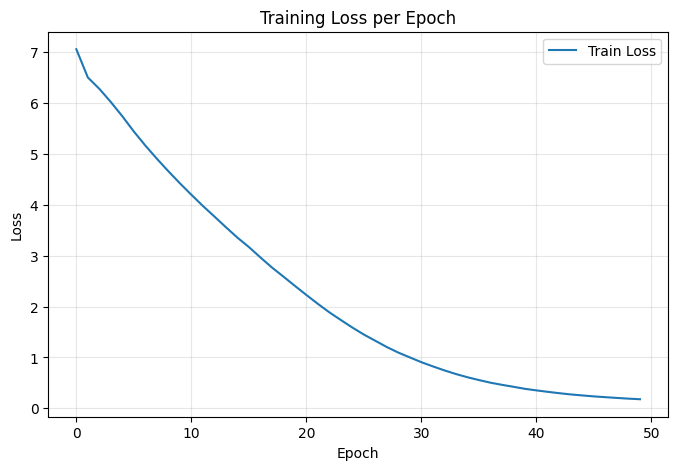

In [94]:
trainer.print_loss_history()

### Задание 1.2

In [102]:
from transformers import GPT2LMHeadModel

class GPT2(nn.Module):
    def __init__(self, vocab_size: int):
        super().__init__()
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt.resize_token_embeddings(vocab_size)
            
    def forward(self, x):
        outputs = self.gpt(input_ids=x)
        return outputs.logits

In [103]:
BATCH_SIZE = 4
EPOCHS = 5
LR = 1e-3
trainer = ModelTrainer(num_epochs=EPOCHS,
                       batch_size=BATCH_SIZE, 
                       pad_token_id=ussr_tokenizer.special_tokens['<PAD>'],
                       device='cuda')

texts = pd.read_csv(dirs['jokes'])[:1000]['text']

dataset = TextDataset(texts, joke_tokenizer, max_length=128)
model = GPT2(joke_tokenizer.vocab_size)
optimizer = Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index=joke_tokenizer.special_tokens['<PAD>'])


In [104]:
trainer.train(dataset, model, optimizer, criterion)

100%|██████████| 1250/1250 [03:41<00:00,  5.65batch/s, Epoch Loss=3.1831]     


array([1.93449557, 1.93099868, 1.68289042, 1.34884119, 1.67716372,
       1.89212191, 1.42227399, 1.68264556, 1.75432563, 2.13778782,
       1.78444088, 1.72219622, 2.01471567, 1.55028999, 1.00121987,
       1.74702537, 1.57207286, 2.32430291, 1.88314903, 2.09373784,
       1.84439087, 1.76650643, 1.7284224 , 1.82119346, 1.95866573,
       1.55254722, 1.7167753 , 1.81201649, 2.06255364, 1.94483685,
       2.12784553, 1.91854441, 2.15358233, 1.79470813, 1.86869884,
       1.43229103, 1.70848799, 1.86993659, 2.23399115, 1.63450003,
       1.5015651 , 1.66306472, 2.16319966, 1.61044872, 2.05296636,
       2.21263433, 2.13292336, 1.48142898, 2.16659021, 2.26007223,
       1.66722548, 1.79405308, 2.07498074, 2.02003264, 2.3188591 ,
       2.08392644, 1.96014607, 2.02928925, 2.12988782, 2.07551813,
       1.48410428, 2.23937321, 1.66286993, 1.66606414, 1.82870591,
       2.16896558, 2.081357  , 2.06396842, 1.92612135, 2.00737023,
       2.14804459, 2.14697456, 1.69350064, 1.50579369, 1.93486

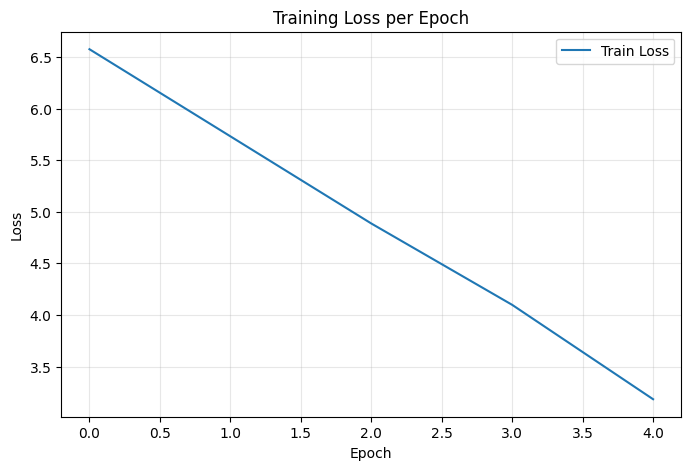

In [105]:
trainer.print_loss_history()